Check suspicious cases eg PRAD: it seems mutational, but there are patients with lots of switches.

In [1]:
source("../data/env/variables.R")
source("../wisdom/code/r/data_analysis_environment.R")
source("../wisdom/code/r/clean_theme.R")
library(RColorBrewer)
library(scales)
options(repr.plot.width=8, repr.plot.height=8)

options("readr.num_columns" = 0)

# read switches
switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    subset(EnoughRecurrence == 1 & NotNoise==1 & IsModel==1 & Origin=="Tumor" & IsFunctional==1)
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & IsFunctional==1)

# read ME with top drivers
me <- lapply(1:10, function(i){
  read_tsv(paste0("../data/mutations/pannegative_mutual_exclusion.top_",i,"_drivers.txt")) %>%
    mutate(NumDrivers = i, Total = M + MS + S + N,
           M.p = M/Total, MS.p = MS/Total, 
           S.p = S/Total, N.p = N/Total,
           SwitchSamples = S + MS)
  }) %>% do.call("rbind",.)

# drivers mutations
mutatedDrivers <- read_tsv("../data/mutations/driver_mutation_number.txt") %>%
    mutate(PatientNumber = unlist(lapply(strsplit(as.character(Samples), ","), length)),
           Rank = as.numeric(do.call("c",by(-PatientNumber, Tumor, rank))))

# read mutations
mutations <- read_tsv("../data/mutations/wes_mutations.txt")

# read mutual exclusion with specific drivers
me.specificDrivers <- read_tsv("../data/mutations/mutual_exclusion_top_drivers.txt") %>%
    mutate(Total = M + MS + S + N, 
           M.p = M/Total, 
           MS.p = MS/Total,
           S.p = S/Total, 
           N.p = N/Total)

## read specific drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  mutate(Tumor_type = ifelse(Tumor_type=="COREAD", "coad", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="HC", "lihc", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="RCCC", "kirc", Tumor_type),
         Tumor_type = tolower(Tumor_type) ) %>%
  set_colnames(c("Symbol","Tumor"))

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric



# Aggregated data

[1] 1662

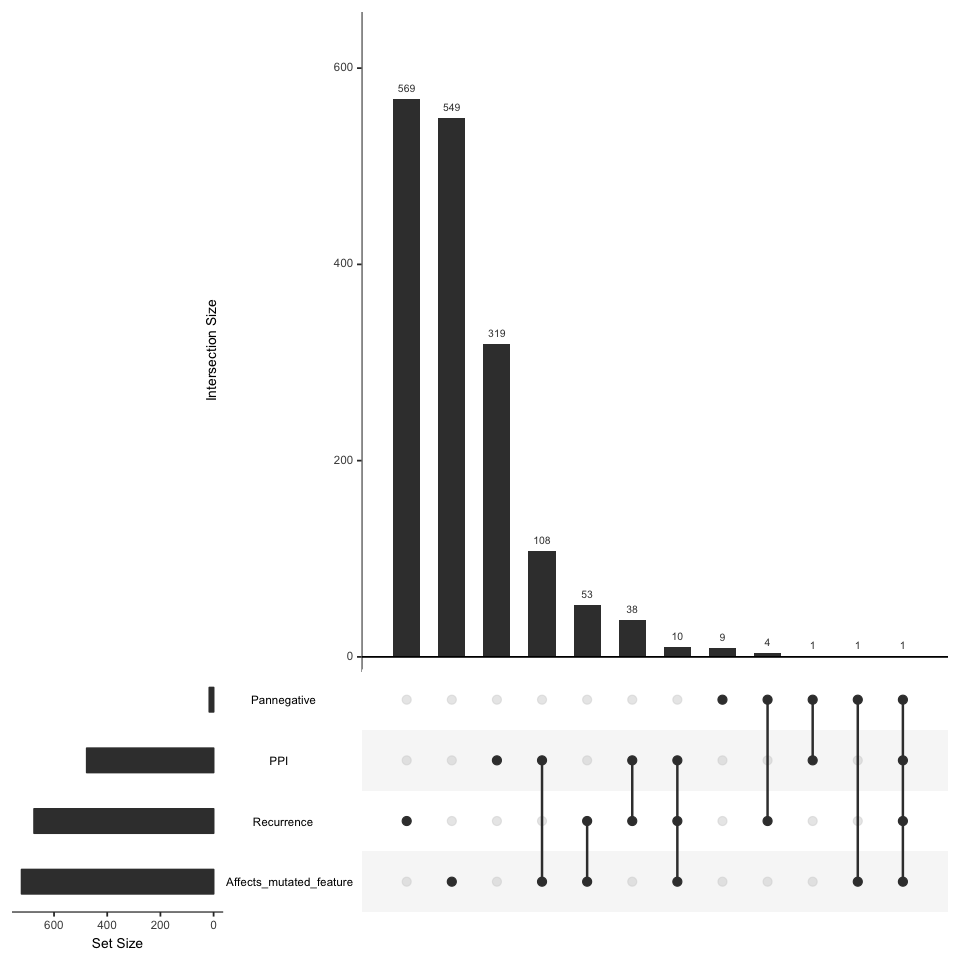

In [2]:
library(UpSetR)

potus <- switches %>%
    filter(Candidate==1) %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript)

nrow(potus)

switches %>%
    filter(Candidate==1) %>%
    select(Recurrence,Affects_mutated_feature,PPI,Pannegative) %>%
    mutate(Pannegative = ifelse(Pannegative > 2, 1,0)) %>%
    as.data.frame %>%
    upset(order.by = "freq", nintersects = 15)

# Tumor-specific

In [3]:
potus %>%
    merge(switches.split) %>%
    group_by(Tumor) %>%
    summarise(Recurrence = sum(Recurrence), Pannegative = sum(Pannegative > 0),
              Affects_mutated_feature = sum(Affects_mutated_feature), PPI = sum(PPI))

Tumor,Recurrence,Pannegative,Affects_mutated_feature,PPI
brca,269,9,110,56
coad,155,0,66,46
hnsc,339,2,177,138
kich,311,0,165,114
kirc,374,0,172,127
kirp,458,2,274,201
lihc,92,0,35,28
luad,263,2,97,59
lusc,240,0,125,69
prad,262,0,102,85


In [4]:
# check that all the patients have at least one switch/mutation
alterationsPerPatient <- lapply(cancerTypes, function(tumor){
  
    # read switches
    tumor.potus <- switches.split %>%
        filter(Tumor==tumor) %>%
        merge(potus)
  
    ## count number of AS drivers switched per patient
    patients <- tumor.potus$Patients_affected %>% strsplit(",") %>% unlist
    switchesPerPatient <- plyr::count(patients) %>%
        set_colnames(c("Patient","Switches"))
  
    # read mutations  
    ## get cancer specific drivers
    tumor.drivers <- drivers$Symbol[drivers$Tumor==tumor]
   
    ## filter out mutations not in drivers
    mutations.drivers <- mutations %>%
        filter(Tumor == tumor) %>%
        filter(Symbol %in% tumor.drivers) %>%
        ## consider only mutated genes, not several mutations in a gene
        select(GeneId,Patient) %>%
        unique
    
    ## count number of mutations per patient
    mutationsPerPatient <- plyr::count(mutations.drivers$Patient) %>%
        set_colnames(c("Patient","Mutations"))
    
    # get patients with both RNAseq and mutation information
    patients.swt <- unique(patients)
    patients.mut <- unique(mutations$Patient)
    patients.common <- intersect(patients.swt,patients.mut)
    
    merge(mutationsPerPatient,switchesPerPatient, all=T) %>%
        mutate(Switches = ifelse(is.na(Switches), 0, Switches/nrow(tumor.potus) ),
               Mutations = ifelse(is.na(Mutations), 0, Mutations/length(tumor.drivers)),
               Tumor = tumor,
               Class = ifelse(Mutations < Switches, "S", "M")) %>%
        filter(Patient %in% patients.common)
  
}) %>% do.call("rbind",.)

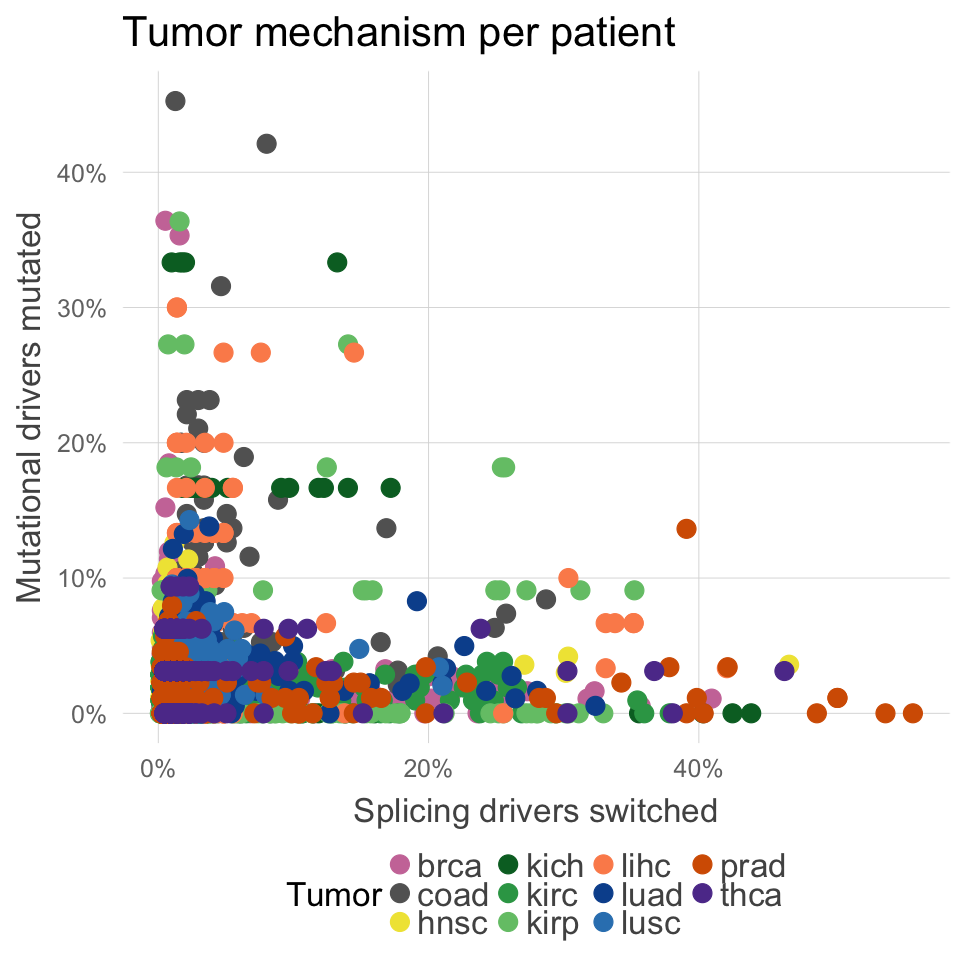

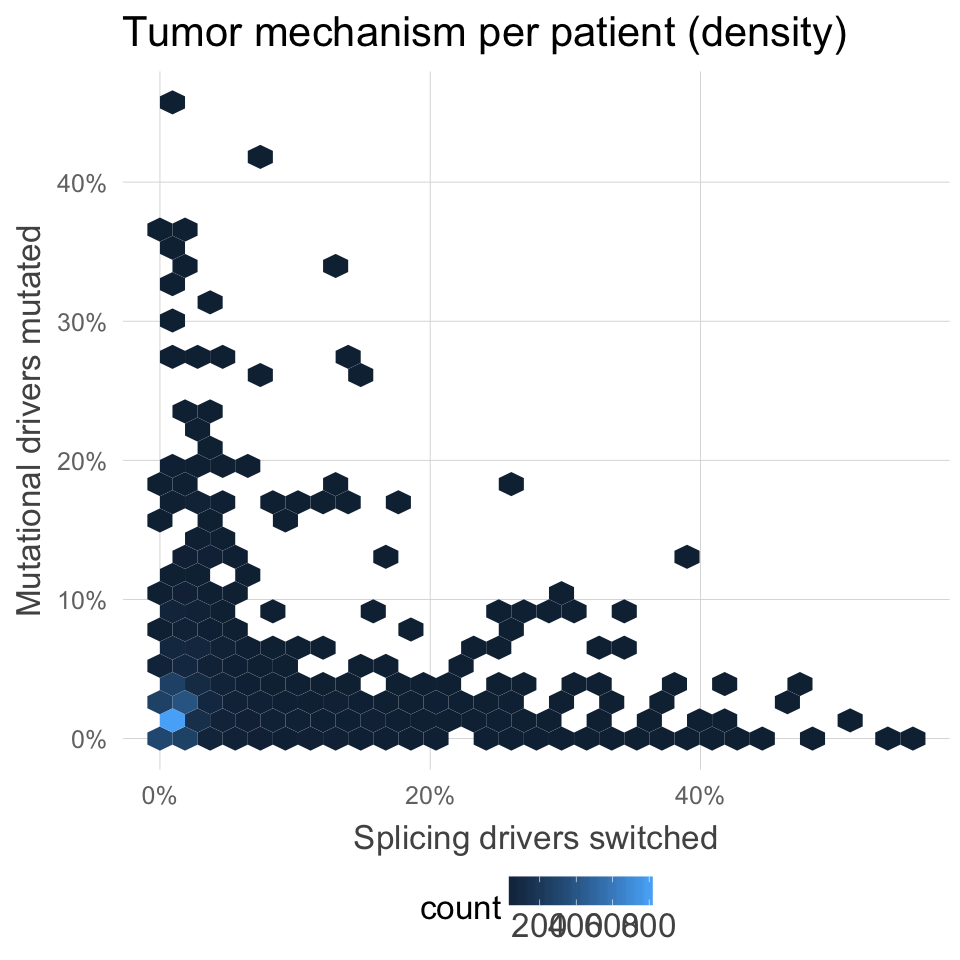

In [5]:
# plot raw frequency
ggplot(alterationsPerPatient,aes(x=Switches,y=Mutations,color=Tumor)) + 
    geom_point(size=5) + 
    clean_theme() +
    labs(x="Splicing drivers switched",y="Mutational drivers mutated", title="Tumor mechanism per patient") +
    scale_color_manual(values=colorPalette) +
    theme(legend.position="bottom") +
    scale_y_continuous(labels = percent) +
    scale_x_continuous(labels = percent)

# plot 2d density
rf <- colorRampPalette(rev(brewer.pal(11,'Spectral')))
ggplot(alterationsPerPatient,aes(x=Switches,y=Mutations)) + 
    stat_binhex() +
    clean_theme() +
    labs(x="Splicing drivers switched",y="Mutational drivers mutated", title="Tumor mechanism per patient (density)") +
    theme(legend.position="bottom") +
    scale_y_continuous(labels = percent) +
    scale_x_continuous(labels = percent)

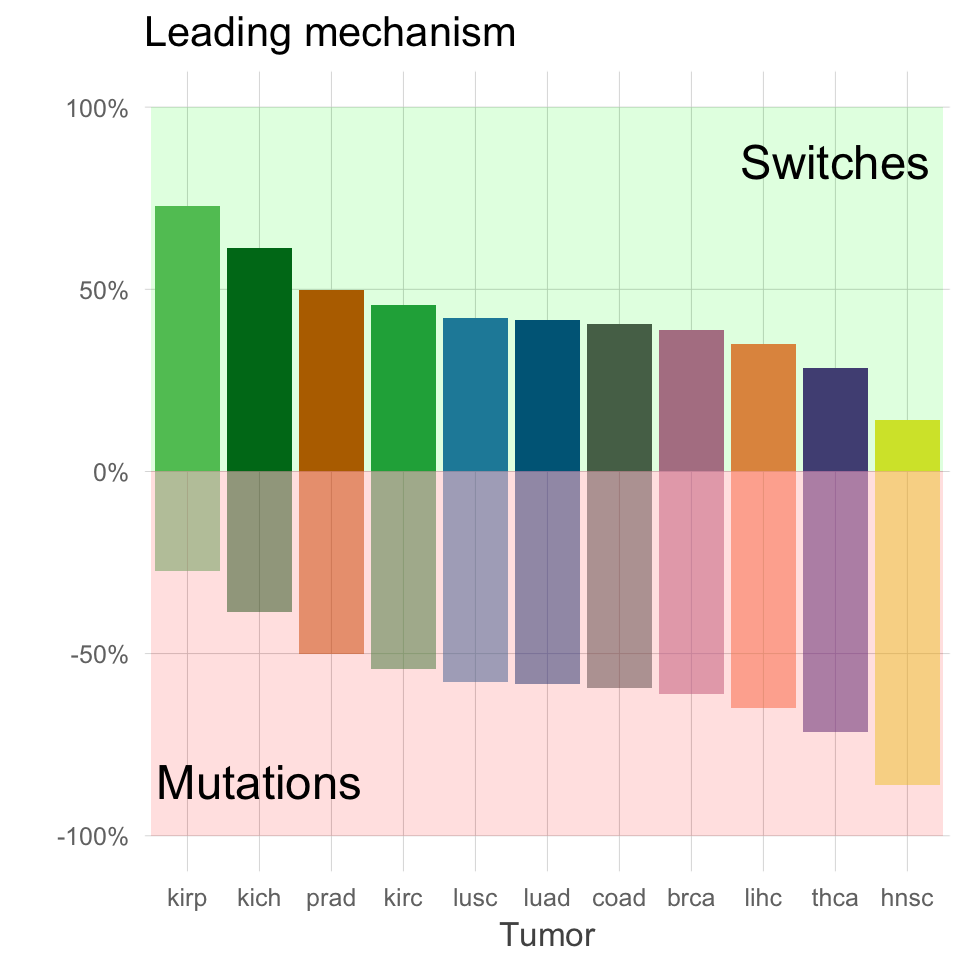

In [6]:
total <- alterationsPerPatient %>%
    plyr::count('Tumor') %>% 
    set_colnames(c("Tumor","Patients"))

tumorClassification <- alterationsPerPatient %>%
    plyr::count(c('Class','Tumor')) %>%
    set_colnames(c("Class","Tumor","Counts")) %>%
    merge(total) %>%
    mutate(Prop = Counts/Patients, Class = factor(Class, levels=c("S","M")),
           Tumor = factor(Tumor, levels=Tumor[Class=="S"][order(-Prop[Class=="S"])]))

ggplot() + 
    geom_bar(data = subset(tumorClassification, Class=="S"),aes(x=Tumor,y=Prop,fill=Tumor),stat="identity") +
    geom_bar(data = subset(tumorClassification, Class=="M"),aes(x=Tumor,y=-Prop,fill=Tumor),stat="identity",alpha=0.5) +
    geom_rect(data = subset(tumorClassification, Class=="M"), aes(xmin=0.5, xmax=11.5, ymin=0, ymax=1), 
              fill = "green", alpha = 0.01) +
    geom_rect(data = subset(tumorClassification, Class=="S"), aes(xmin=0.5, xmax=11.5, ymin=0, ymax=-1), 
              fill = "red", alpha = 0.01) +
    geom_text(aes(x=10,y=.85,label="Switches"), size=10) +
    geom_text(aes(x=2,y=-.85,label="Mutations"), size=10) +
    scale_fill_manual(values=colorPalette) +
    labs(y="",title="Leading mechanism") +
    scale_y_continuous(labels = percent) +
    clean_theme()

# Category split
## [PPI](../structural_analysis/ppi.ipynb)
## Pan-negative

Study switches that (a) are mutually exclusive with at least the 3 most frequent drivers in a tumor type and (b) present a pattern of mutual exclusion with a driver located in the same pathway.

### Pan-negative

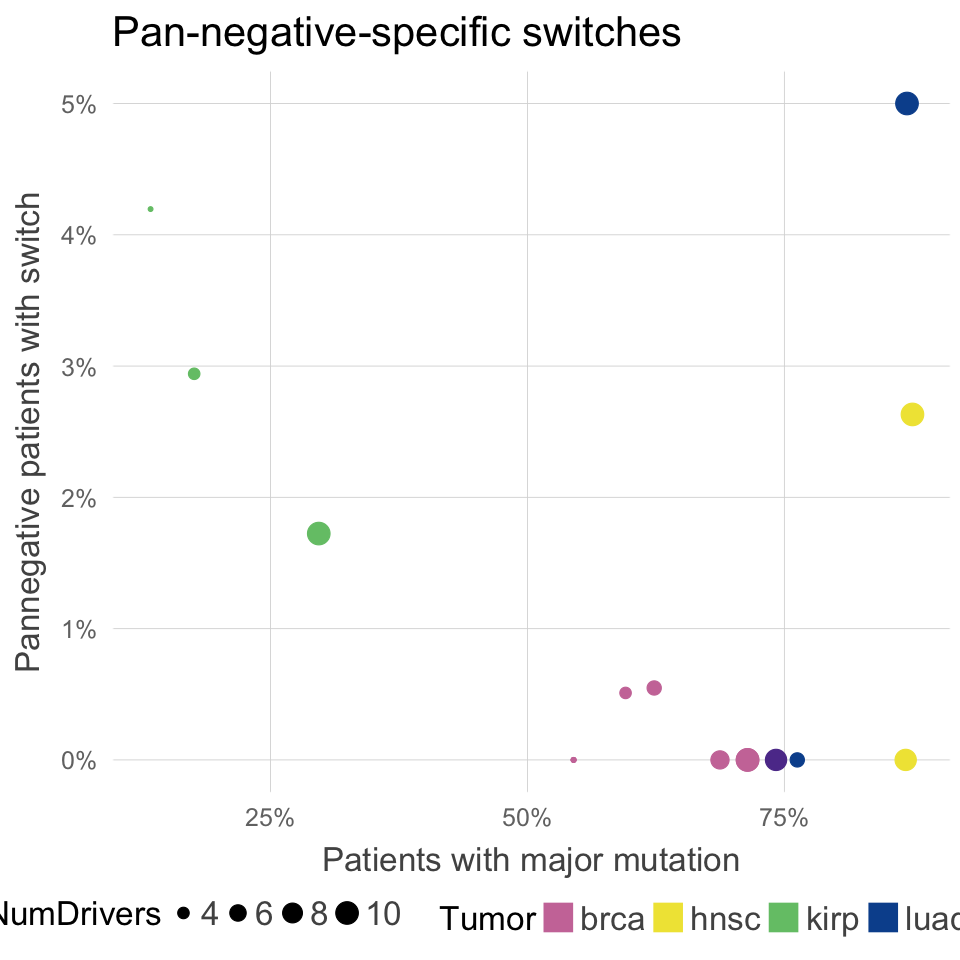

In [7]:
potus.pn <- switches %>%
    filter(Candidate==1 & Pannegative > 0 & Origin=="Tumor") %>%
    merge(me) %>%
    filter(p.me < 0.05) %>%
    by(., paste0(.$GeneId,.$Tumor), 
         function(X) X[which.max(X$NumDrivers),]) %>%
    do.call("rbind",.)
             
ggplot(potus.pn, aes(x = M.p+MS.p, y = S/(N+S), color = Tumor)) + 
    geom_point(aes(size = NumDrivers)) + 
#     geom_text_repel(aes(label=Symbol)) +
    clean_theme() +
    scale_color_manual(values=colorPalette) +
    labs(x="Patients with major mutation", y="Pannegative patients with switch",title="Pan-negative-specific switches") +
    theme(legend.position="bottom") +
    guides(col = guide_legend(override.aes = list(shape = 15, size = 8))) +
    scale_y_continuous(labels = percent) +
    scale_x_continuous(labels = percent)

The previous plot misses one dimension: the overlap between switches and mutations.

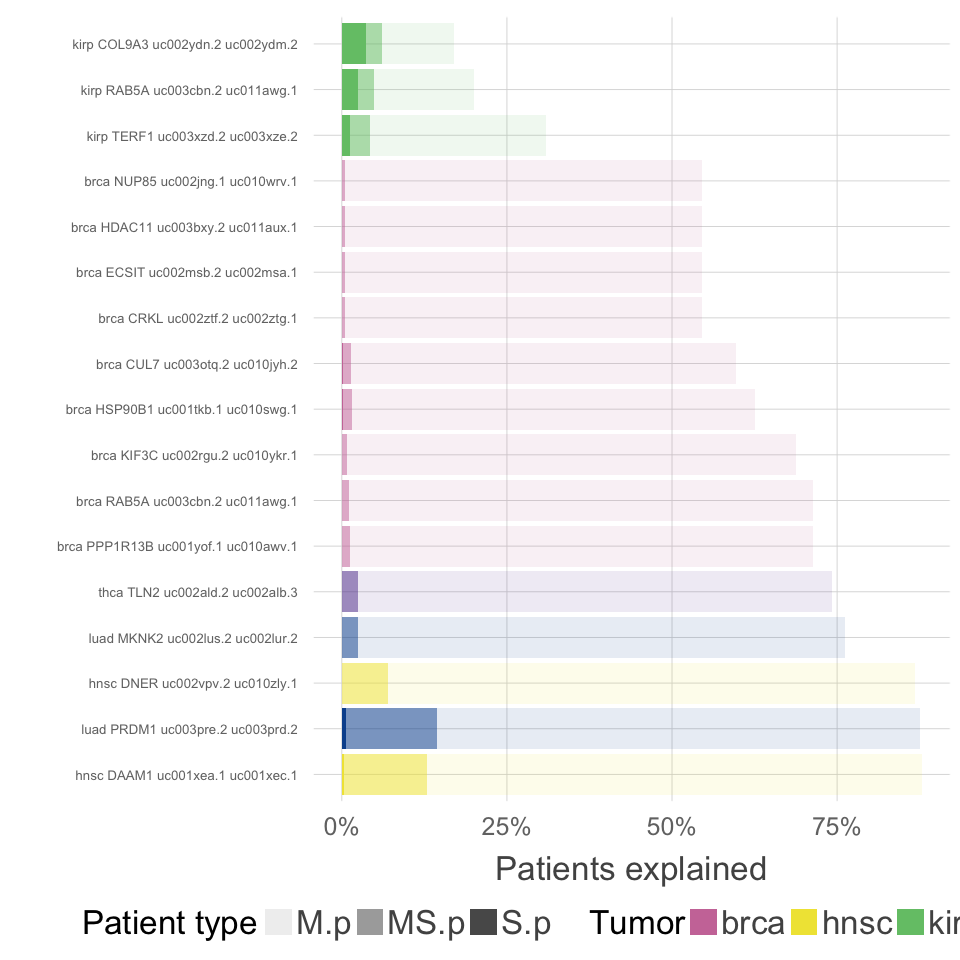

In [8]:
# prepare data
## order genes by total number of patients explained
df <- potus.pn %>%
    select(Tumor,GeneId,Symbol,Normal_transcript,Tumor_transcript,MS.p,M.p,S.p) %>%
    mutate(Switch = as.character(paste(Tumor,Symbol,Normal_transcript,Tumor_transcript))) %>%
    arrange(-(MS.p+M.p+S.p)) %>%
    mutate(Switch = factor(Switch,levels=Switch)) %>%
    select(Tumor,Switch,M.p,MS.p,S.p)

# show in detail
reshape2::melt(df, id.vars=c('Tumor','Switch')) %>%
    mutate(variable = factor(variable,levels=c("M.p","MS.p","S.p"))) %>%
    ggplot(aes(x=Switch,y=value, alpha=variable, fill=Tumor)) +
        geom_bar(stat="identity") +
        labs(x="", y="Patients explained", alpha="Patient type") +
        scale_fill_manual(values=colorPalette) +
        clean_theme() +
        theme(legend.position="bottom", axis.text.y=element_text(size=8)) +
        scale_y_continuous(labels = percent) +
        coord_flip()

### Mutational drivers

Tumor,Symbol,DriverSymbol,Pathway
kirp,COL9A3,MET,"DEVELOPMENTAL BIOLOGY, AXON GUIDANCE, SYNDECAN 1 PATHWAY"
brca,CRKL,TP53,"NEUROTROPHIN SIGNALING PATHWAY, CHRONIC MYELOID LEUKEMIA, MAPK SIGNALING PATHWAY, PATHWAYS IN CANCER"
hnsc,DAAM1,TP53,WNT SIGNALING PATHWAY
brca,PPP1R13B,TP53,P53DOWNSTREAMPATHWAY
hnsc,PPP1R13B,CDKN2A,"SIG PIP3 SIGNALING IN B LYMPHOCYTES,SIG PIP3 SIGNALING IN CARDIAC MYOCTES,ST PHOSPHOINOSITIDE 3 KINASE PATHWAY"
luad,MKNK2,TP53,MAPK SIGNALING PATHWAY


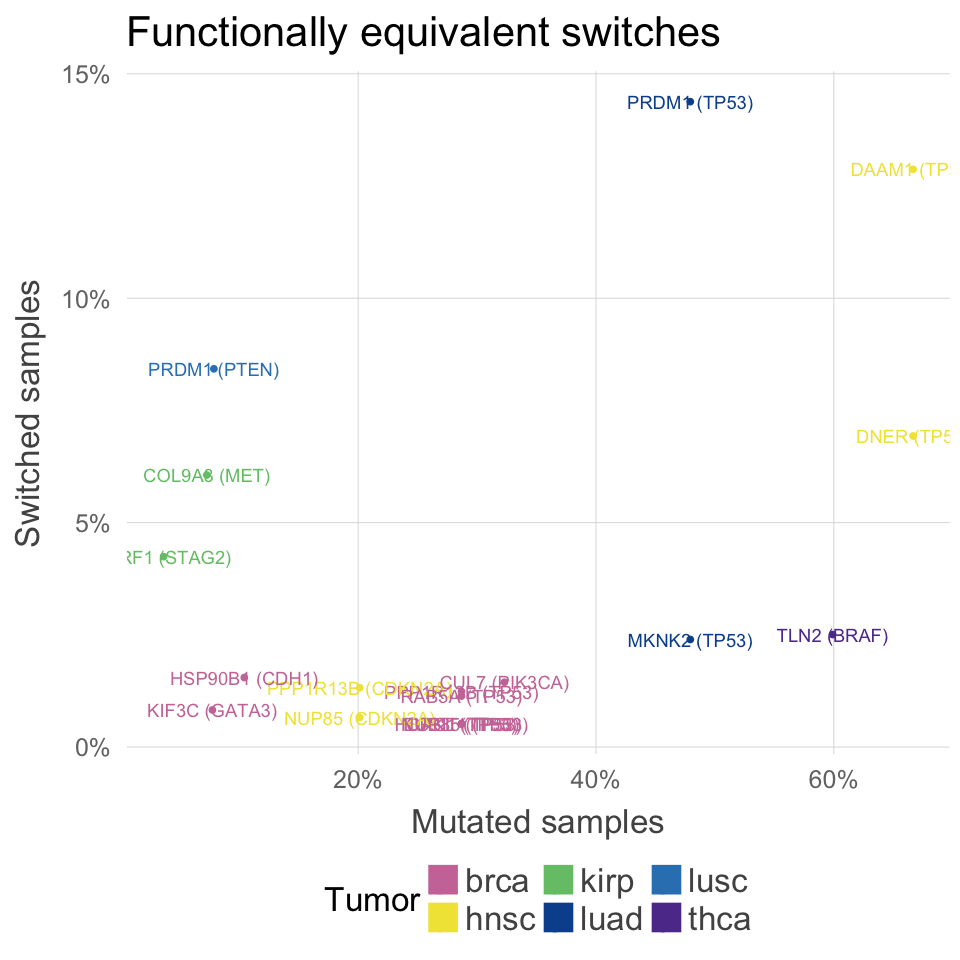

In [9]:
potus.d <- switches %>%
    filter(Candidate==1 & Pannegative > 0 & Origin=="Tumor") %>%
    merge(me.specificDrivers, by=c("GeneId","Symbol","Normal_transcript","Tumor_transcript")) %>%
    filter(p.me < 0.05 & Pathway!="")

potus.d %>%
    select(Tumor, Symbol, DriverSymbol, Pathway) %>%
    mutate(Pathway = gsub("_"," ",Pathway),
           Pathway = gsub("KEGG|REACTOME|PID","",Pathway)) %>%
    head

ggplot(potus.d, aes(x = MS.p+M.p, y = MS.p+S.p, color = Tumor)) + 
    geom_point() +
    geom_text(aes(label=paste0(Symbol," (",DriverSymbol,")"))) +
    labs(x="Mutated samples", y="Switched samples", title="Functionally equivalent switches") +
    scale_color_manual(values=colorPalette) +
    clean_theme() +
    theme(legend.position="bottom") +
    guides(col = guide_legend(override.aes = list(shape = 15, size = 8))) +
    scale_y_continuous(labels = percent) +
    scale_x_continuous(labels = percent)

# On network, driver-like properties


	Wilcoxon rank sum test with continuity correction

data:  driverEvidence %>% filter(Candidate == 1) %>% .$Centrality and driverEvidence %>% filter(Candidate == 0) %>% .$Centrality
W = 4282600, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


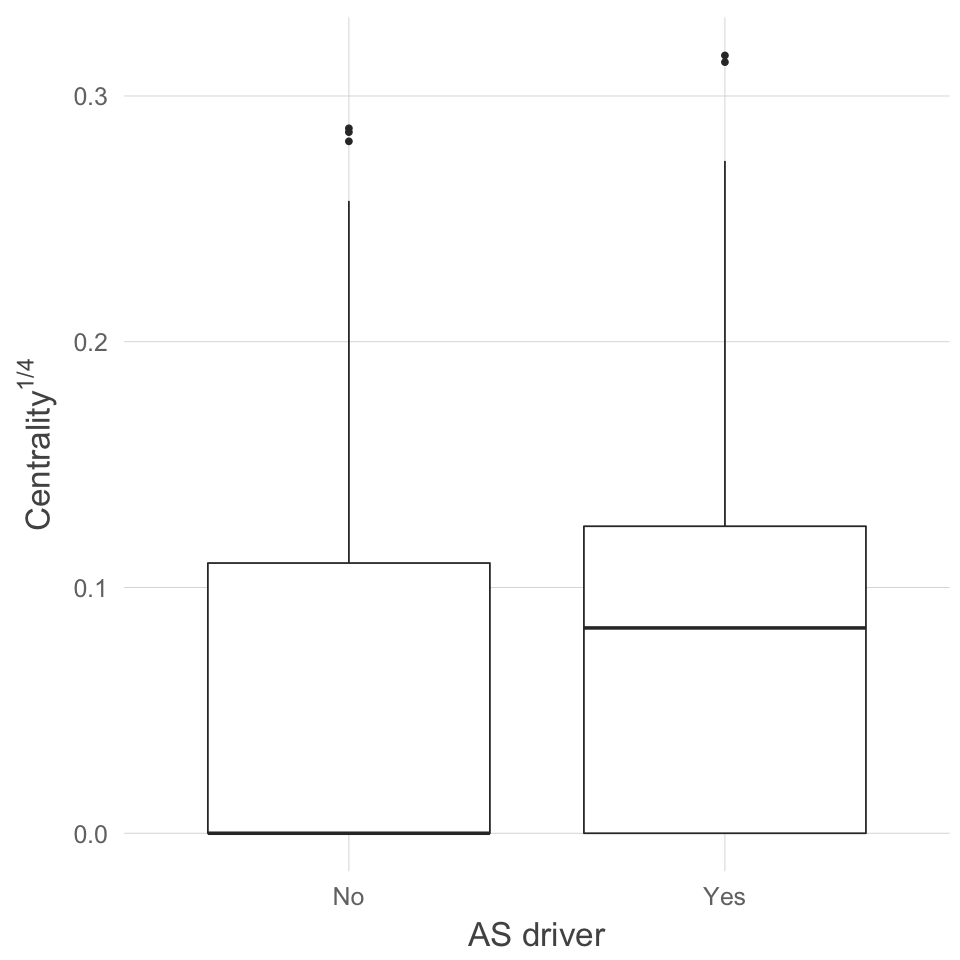

In [10]:
driverEvidence <- read_tsv("../data/switches/driverEvidence.tsv") %>% 
    merge(switches) %>%
    select(Normal_transcript, Tumor_transcript, Candidate, Centrality,
           Recurrence, Affects_mutated_feature, PPI, Pannegative, CDD) %>%
    unique

driverEvidence %>%
    ggplot(aes(x = ifelse(Candidate == 1, "Yes", "No"), y = Centrality ^ (1/4))) +
        geom_boxplot() +
        labs(x = "AS driver", y = bquote('Centrality' ^'1/4')) +
        clean_theme()

wilcox.test(driverEvidence %>% filter(Candidate == 1) %>% .$Centrality,
            driverEvidence %>% filter(Candidate == 0) %>% .$Centrality)

In [11]:
# calculate number of potus with significantly higher centrality that non-potus
expected_centrality <- ecdf(driverEvidence %>% filter(Candidate == 0) %>% .$Centrality)
p <- expected_centrality(driverEvidence %>% filter(Candidate == 1) %>% .$Centrality)

sum(p > 0.95)
sum(p > 0.95)/nrow(driverEvidence %>% filter(Candidate == 1)) * 100

[1] 161

[1] 9.687124

potus$ASdriver: Affects_mutated_feature
[1] 0.0001050566
------------------------------------------------------------ 
potus$ASdriver: Pannegative
[1] 0.002332624
------------------------------------------------------------ 
potus$ASdriver: PPI
[1] 2.706608e-151
------------------------------------------------------------ 
potus$ASdriver: Recurrence
[1] 0.01976782

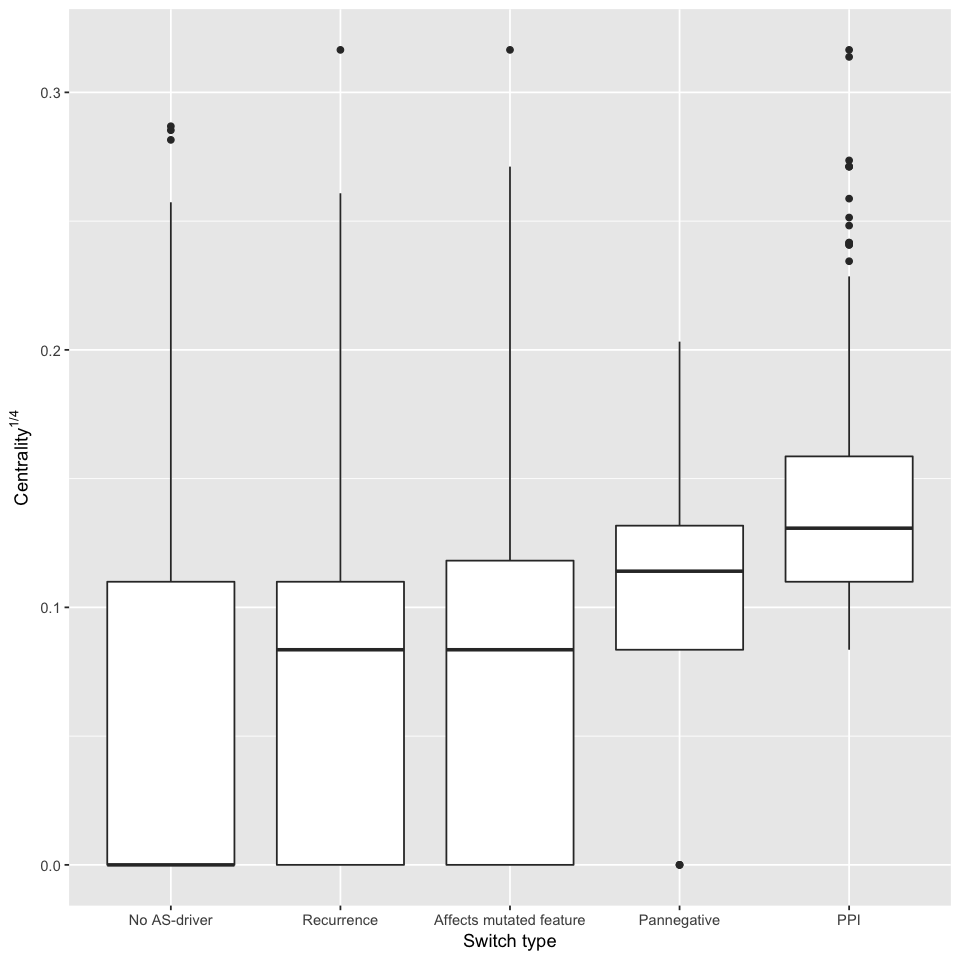

In [12]:
noPotus <- driverEvidence %>%
    filter(Candidate == 0) %>%
    select(Candidate, Centrality) %>%
    set_colnames(c("ASdriver", "Centrality")) %>%
    mutate(ASdriver = "No AS-driver")

potus <- driverEvidence %>%
    filter(Candidate == 1) %>%
    select(Recurrence, Affects_mutated_feature, PPI, Pannegative, Centrality) %>%
    gather("ASdriver", "Val", Recurrence:Pannegative) %>%
    filter(Val > 0) %>%
    select(-Val)

rbind(potus, noPotus) %>%
    mutate(ASdriver = ifelse(ASdriver == "Affects_mutated_feature", 
                             "Affects mutated feature", ASdriver),
           ASdriver = factor(ASdriver, levels = c("No AS-driver", "Recurrence", 
                                                  "Affects mutated feature",
                                                  "Pannegative", "PPI"))) %>%
    ggplot(aes(x = ASdriver, y = Centrality ^ (1/4))) + 
        geom_boxplot() +
        labs(x = "Switch type", y = bquote('Centrality' ^'1/4'))

by(potus, potus$ASdriver, function(x) {
    wilcox.test(x$Centrality, noPotus$Centrality)$p.value
})


	Fisher's Exact Test for Count Data

data:  .
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.530027 1.930302
sample estimates:
odds ratio 
  1.718204 


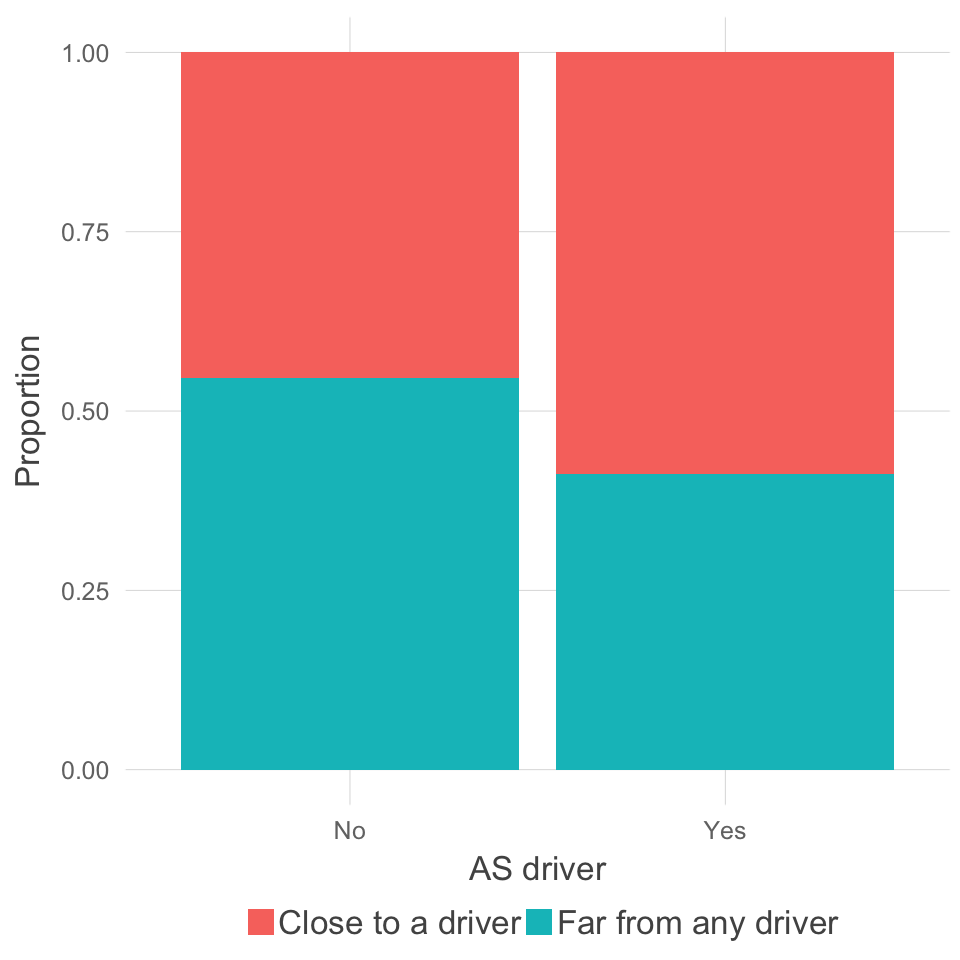

In [13]:
driverEvidence %>% 
    mutate(CDD = ifelse(CDD <= 3, "Close to a driver", "Far from any driver")) %>%
    ggplot(aes(x = ifelse(Candidate == 1, "Yes", "No"), fill = CDD)) +
        geom_bar(position = "fill") +
        labs(x = "AS driver", fill = "", y = "Proportion") +
        clean_theme() +
        theme(legend.position="bottom")

driverEvidence %>% 
    mutate(CDD = CDD <= 3) %>%
    select(CDD,Candidate) %>%
    table %>%
    fisher.test

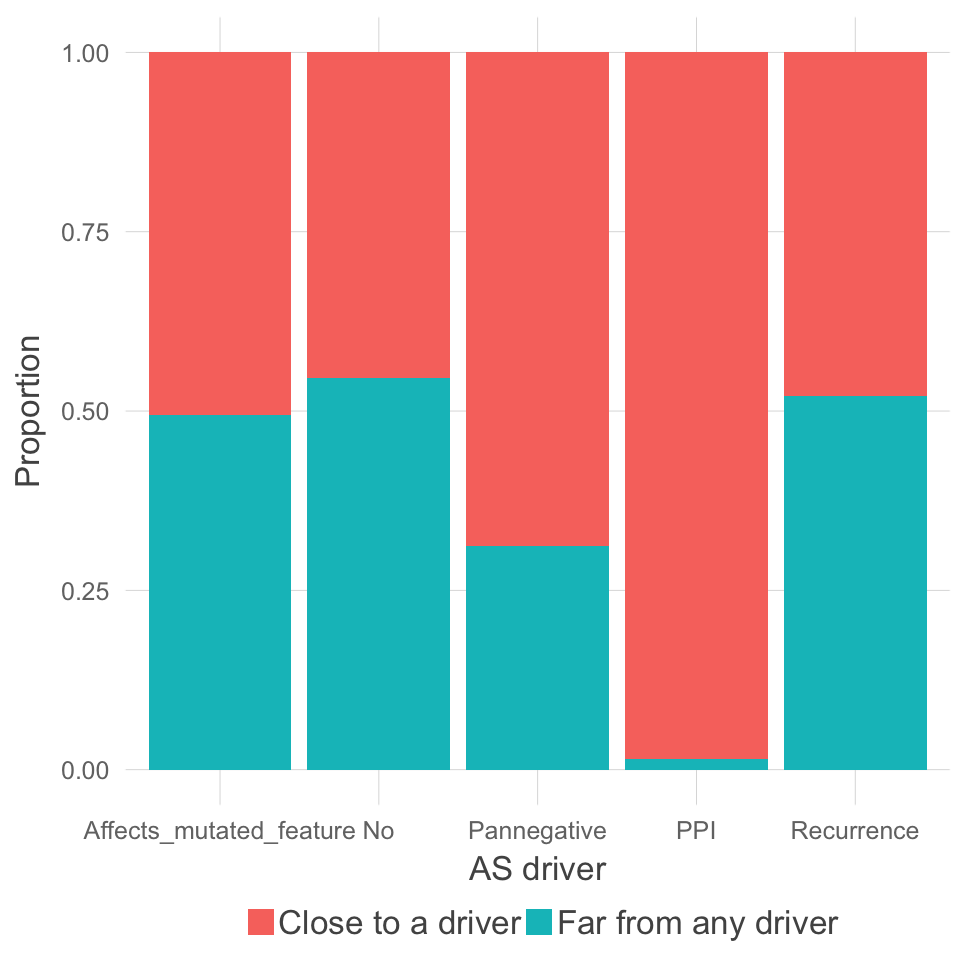

In [14]:
neg <- driverEvidence %>%
    filter(Candidate == 0) %>%
    mutate(CDD = ifelse(CDD <= 3, "Close to a driver", "Far from any driver")) %>%
    select(Candidate, CDD) %>%
    set_colnames(c("ASdriver", "CDD")) %>%
    mutate(ASdriver = "No")

driverEvidence %>%
    filter(Candidate == 1) %>%
    mutate(CDD = ifelse(CDD <= 3, "Close to a driver", "Far from any driver")) %>%
    select(Recurrence, Affects_mutated_feature, PPI, Pannegative, CDD) %>%
    gather("ASdriver", "Val", Recurrence:Pannegative) %>%
    filter(Val > 0) %>%
    select(-Val) %>%
    rbind(neg) %>%
    ggplot(aes(x = ASdriver, fill = CDD)) + 
        geom_bar(position = "fill") +
        labs(x = "AS driver", fill = "", y = "Proportion") +
        clean_theme() +
        theme(legend.position="bottom")